# COMP5328 - Advanced Machine Learning
## Assignment 1: NMF Algorithms – Code

---

# 1. Import Libraries
- 导入 numpy, scipy, matplotlib
- （如果需要）导入 sklearn 用于评估指标
- 设置随机种子，保证结果可复现

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fontTools.misc.cython import returns
from imageio.core import Array
from skimage.util import random_noise
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, accuracy_score
from scipy.optimize import linear_sum_assignment
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt




# 2. Load Datasets
## 2.1 YaleB Dataset
- 加载 ORL 图像数据
- reshape 成矩阵 V
- 归一化 (0-1)

[0.08856149 0.08856149 0.10846523 ... 0.71947694 0.73297673 0.70293504]
[ 0  0  0 ... 37 37 37]


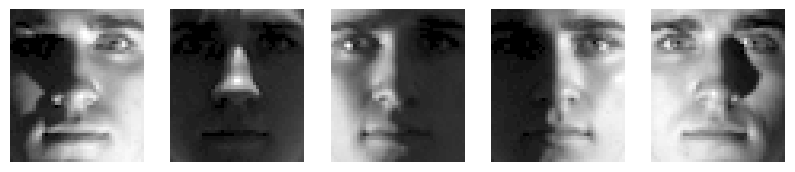

In [15]:
def load_data(root='data/CroppedYaleB', reduce=4):
    images, labels = [], []
    for i, person in enumerate(os.listdir(root)):
        person_dir = os.path.join(root, person)
        if not os.path.isdir(person_dir):
            continue
        for file_name in sorted(os.listdir(person_dir)):
            if file_name.endswith('Ambient.pgm'):
                continue
            if not file_name.endswith('.pgm'):
                continue
            img = Image.open(os.path.join(person_dir, file_name)).convert('L')
            w, h = img.size
            img_resized = img.resize([s//reduce for s in img.size])

            # convert to np array
            img_np = np.array(img_resized, dtype=np.uint8)

            # preprocessing
            # highlight the shadow

            img_np = np.asarray(img_np, dtype=np.float32) / 255.0
            gamma = 0.5
            img_np = np.power(img_np, gamma)

            img_flat = np.asarray(img_np).reshape((-1,1))

            # collect data and label.
            images.append(img_flat)
            labels.append(i)


    images = np.concatenate(images, axis=1)
    labels = np.array(labels)
    return images, labels

images, labels = load_data()
# the images have been scaled to 0, 1
print(images[:, 0])
print(labels[:])
# demonstrate the first 5 images.
plt.figure(figsize=(10,10))
for i in range(5):
    img0 = images[:, i]
    img0 = np.reshape(img0, (192//4, 168//4))
    plt.subplot(1,5, i + 1)
    plt.axis('off')
    plt.imshow(img0, cmap='gray')


plt.axis('off')
plt.show()


## 2.2 Load ORL Dataset


# 3. Noise Generation
## 3.1 Salt & Pepper Noise

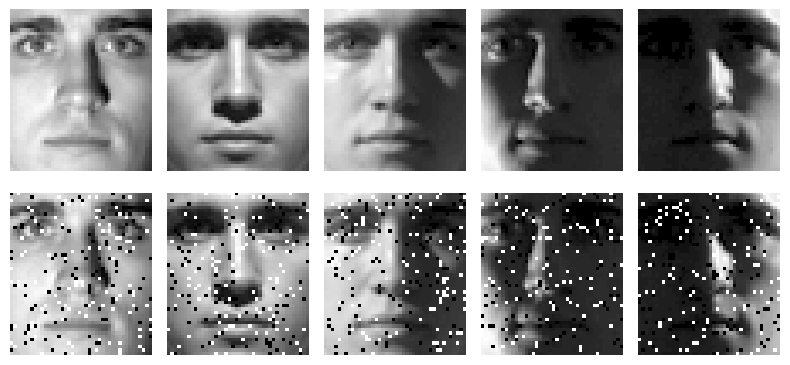

In [4]:
# Adding salt and pepper noise
def aad_salt_pepper_noise(imgs: np.ndarray, p = 0.1, r = 0.5):
    noisy_img = np.copy(imgs)
    for i in range(noisy_img.shape[1]):
        length = noisy_img.shape[0]

        # noisy_img = img.copy()
        # height, weight = img.shape
        # pixels_cnt = height * weight

        # the count of noisy
        noisy_cnt = int(p * length)

        # choosing the pixels randomly
        coordinates = np.random.choice(length, size=noisy_cnt, replace=False)

        # setting the salt
        salt_cnt = int(r * noisy_cnt)
        salt_idx = coordinates[:salt_cnt]
        noisy_img[salt_idx, i] = 1.0

        pepper_cnt = coordinates[salt_cnt:]
        noisy_img[pepper_cnt, i] = 0.0

    return noisy_img

# adding noisy to all the images
noisy_img = aad_salt_pepper_noise(images, 0.1, 0.5)

# visualization
n = 5
h, w = (192//4, 168//4)
plt.figure(figsize=(8,4))
for i in range(n):
    # clean
    clean = images[:, i + 5].reshape(h, w)
    ax1 = plt.subplot(2, n, i + 1)
    ax1.imshow(clean, cmap='gray')
    ax1.axis('off')
    if i == 0:
        plt.ylabel("Clean", fontsize=12)

    # after adding noisy
    noisy = noisy_img[:, i + 5].reshape(h, w)
    plt.subplot(2, n, n + i + 1)
    plt.imshow(noisy, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Noisy", fontsize=12)

plt.tight_layout()
plt.show()

## 3.2 Custom Noise



# 4. NMF Algorithms Implementation (Core)
## 4.1 Standard NMF (Baseline)
- 目标函数：L2 范数
- 优化方法：乘法更新规则 (MU) 或交替最小二乘 (ALS)
- 函数：`nmf_standard(V, rank, max_iter)`

In [5]:
# The standard NMF algorithm
def nmf_standard(V, rank = 40, max_iter = 200, tol = 1e-4, seed = 0, verbose = True):
    np.random.seed(seed)
    m, n = V.shape
    W = np.random.rand(m, rank)
    H = np.random.rand(rank, n)

    # store the loss to draw the variance of loss
    loss_history = []

    # prevent to divide 0
    eps = 1e-9

    for it in range(max_iter):
        # update H
        H = H * (W.T @ V) / (W.T @ W @ H + eps)
        # update W
        W = W * (V @ H.T) / (W @ H @ H.T + eps)
        V_hat = W @ H

        loss = np.linalg.norm(V - V_hat, 'fro')
        loss_history.append(loss)

        if verbose and it % 50 == 0:
            print(f'iter = {it}, loss = {loss:.4f}')

        # if there is no change in new iter pause the training
        if it > 1 and abs(loss_history[-2] -loss) < tol:
            break

    return W, H, loss_history



## 4.2 Robust NMF (L1 / L2,1 Variant)
- 目标函数：L1 或 L2,1 范数
- 优化方法：子梯度 / 加权更新
- 函数：`nmf_robust(V, rank, max_iter)`

---


# 5. Evaluation Metrics
## 5.1 Relative Reconstruction Error (RRE)

In [6]:
def compute_ree(V, W, H):
    V_hat = W @ H
    return np.linalg.norm(V - V_hat, 'fro') / np.linalg.norm(V, 'fro')

## 5.2 Accuracy
- 使用 KMeans 聚类
- 计算聚类标签 vs 真实标签
- 函数：`compute_accuracy(Y_true, Y_pred)`

In [40]:
# Compute accuracy by K-means
def compute_acc(Y: np.ndarray, H, n_clusters):
    km = KMeans(n_clusters=n_clusters, random_state=0, n_init=50).fit(H.T)
    Y_pred = km.labels_
    # Hungarian
    D = max(Y_pred.max(), Y.max()) + 1
    cost = np.zeros((D, D))
    for i in range(len(Y_pred)):
        # calculate how many labels are matched
        cost[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(cost.max() - cost)
    return sum(cost[i, j] for i, j in zip(row, col)) / len(Y_pred)

## 5.3 Normalized Mutual Information (Optional)
- 使用 sklearn.metrics
- 函数：`compute_nmi(Y_true, Y_pred)`

---


# 6. Experiments
## 6.1 Run NMF on ORL Dataset
- 在 ORL 数据集上分别跑标准 NMF 和鲁棒 NMF
- 保存结果


## 6.2 Run NMF on YaleB Dataset
- 在 YaleB 数据集上分别跑标准 NMF 和鲁棒 NMF
- 保存结果

In [41]:
# Training W H of the NMF algorithm on the YaleB
result = nmf_standard(images,max_iter=200,rank=100)
W, H, loss_list = result

iter = 0, loss = 438.2104
iter = 50, loss = 210.8318
iter = 100, loss = 166.5292
iter = 150, loss = 143.2513


In [42]:
K = len(np.unique(labels))
print("unique labels:", K)
# Ree
REE = compute_ree(images, result[0], result[1])
print("REE = {:.4f}".format(REE))
# Accuracy
Acc = compute_acc(labels, result[1], K)
print("Acc = {:.4f}".format(Acc))

unique labels: 38
REE = 0.1137
Acc = 0.2038


In [43]:
# Training W H on YaleB After Adding noisy
result = nmf_standard(noisy_img,max_iter=200, rank=100)
W1, H1, loss_list1 = result

iter = 0, loss = 530.2854
iter = 50, loss = 400.0624
iter = 100, loss = 380.1823
iter = 150, loss = 370.4827


In [44]:
K = len(np.unique(labels))
print("unique labels:", K)
# Ree
REE = compute_ree(images, W1, H1)
print("REE = {:.4f}".format(REE))
# Accuracy
Acc = compute_acc(labels, H1, K)
print("Acc = {:.4f}".format(Acc))

unique labels: 38
REE = 0.1452
Acc = 0.1943



## 6.3 Run with Different Noise Levels (p, r)
- 实验参数：p = 0.2, 0.4, 0.6; r = 0.3, 0.7
- 循环运行，重复 5 次取均值和标准差
- 存储结果为表格

---


# 7. Results
## 7.1 Visualization of Original vs Noisy Images
- 绘制原始图像 + 噪声图像对比

## 7.2 Reconstruction Examples
- 展示重构前后图像（标准 NMF vs 鲁棒 NMF）

## 7.3 Quantitative Results (Tables & Graphs)
- RRE 对比表格
- Accuracy/NMI 曲线
- 不同噪声水平下的对比柱状图